In [32]:
# Data Tools
import numpy as np
import pandas as pd
import math
from scipy import stats
from scipy.stats import sem

# Visualization Tools
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Student's T-Test
from scipy.stats import ttest_ind

# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Model Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Print Confusion Matrix
def print_confusion_matrix(y_test, y_pred):
    print('Confusion Matrix:')
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)
    print('Accuracy: {:0.2f}%'.format((matrix[0][0] + matrix[1][1]) * 100 / matrix.sum()))
    print('Recall: {:0.2f}%'.format(matrix[0][0] * 100 / (matrix[0][0] + matrix[1][0])))
    print('Precision: {:0.2f}%'.format(matrix[0][0] * 100 / (matrix[0][0] + matrix[0][1])))

# Set Confusion Matrix
def set_confusion_matrix(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    accuracy = (matrix[0][0] + matrix[1][1]) * 100 / matrix.sum()
    recall = matrix[0][0] * 100 / (matrix[0][0] + matrix[1][0])
    precision = matrix[0][0] * 100 / (matrix[0][0] + matrix[0][1])
    return {
        'matrix': matrix,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

# Feature Engineering Function
def feature_engineer(data):
    data_copy = data.copy()
    print(data.columns)
    
    # Engineer based on Name
    data_copy['Prefix'] = data_copy.Name.apply(lambda x: x.split(', ')[1].split('. ')[0] if x.split(', ')[1].split('. ')[0] in regular_prefixes else 'Special')

    # Impute Age using averages per gender (moved to beginning to apply before train/test split)
    # genders = ['male', 'female']
    # for g in genders:
    #     for p in data_copy.Prefix.unique():
    #         data_copy.loc[(data_copy.Sex == g) & (data_copy.Prefix == p) & (data_copy.Age.isna()), 'Age'] = data_copy.loc[(data_copy.Sex == g) & (data_copy.Prefix == p)].Age.mean()

    # Transform SibSp and Parch values to 0 or 1
    data_copy['SibSp_bin'] = (data_copy.SibSp >= 1).apply(lambda x: int(x))
    data_copy['Parch_bin'] = (data_copy.Parch >= 1).apply(lambda x: int(x))

    # One-Hot Encoding
    cat_cols = [
        'Prefix',
        'Pclass',
        'Sex',
        'Embarked',
    ]
    for col in cat_cols:
        data_copy = data_copy.join(pd.get_dummies(data_copy[col], prefix=col, drop_first=True))

    # Normalize Numeric Features (Z-Score)
    num_cols = [
        'Age',
        'Fare',
    ]
    for col in num_cols:
        col_name = col + '_normalized'
        data_copy[col_name] = data_copy[col].apply(lambda x: (x - data_copy[col].mean()) / data_copy[col].std())

    # Drop Old + Misc columns
    data_copy.drop([
        'PassengerId',
        'Prefix',
        'Sex',
        'Name',
        'Ticket',
        'Cabin',
        'Embarked',
        'Age',
        'Fare',
        'SibSp',
        'Parch',
        'Pclass'
    ], axis=1, inplace=True)

    # Check if expected columns are present
    expected_columns = ['SibSp_bin', 'Parch_bin', 'Prefix_Miss', 'Prefix_Mr', 'Prefix_Mrs', 'Prefix_Special', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S']
    for col in expected_columns:
        if (col not in data_copy.columns):
            data_copy[col] = 0

    # Ensure correct order of columns
    all_columns = ['SibSp_bin', 'Parch_bin', 'Prefix_Miss', 'Prefix_Mr', 'Prefix_Mrs', 'Prefix_Special', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age_normalized', 'Fare_normalized', 'Survived']
    data_copy = data_copy.loc[:, all_columns]

    # Drop features that don't help
    drop_features = []
    for f in drop_features:
        data_copy.drop(f, axis=1, inplace=True)

    return data_copy.drop('Survived', axis=1), data_copy['Survived'], data_copy

# Feature Engineering (Old)
def feature_engineer_old(data):
    data_copy = data.copy()

    # Impute Age
    genders = ['male', 'female']

    for g in genders:
        data_copy.loc[(data_copy.Sex == g) & (data_copy.Age.isna()), 'Age'] = data_copy.loc[data_copy.Sex == g].Age.mean()

    # Get Cabin Letter
    data_copy['Cabin_letter'] = data_copy.Cabin.fillna('_').str[0]

    # Get Mode for Embarked
    modeEmbarked = data_copy['Embarked'].mode()
    data_copy.Embarked.fillna(modeEmbarked, inplace=True)

    # One-Hot Encoding
    cat_cols = [
        'Pclass',
        'Sex',
        'Embarked'
    ]
    for col in cat_cols:
        data_copy = data_copy.join(pd.get_dummies(data_copy[col], prefix=col, drop_first=True))

    # Normalize Numeric Features (Z-Score)
    num_cols = [
        'Age',
        'Fare',
        'SibSp',
        'Parch'
    ]
    for col in num_cols:
        col_name = col + '_normalized'
        data_copy[col_name] = data_copy[col].apply(lambda x: (x - data_copy[col].mean()) / data_copy[col].std())

    # Drop Old + Misc columns
    data_copy.drop([
        'PassengerId',
        'Sex',
        'Name',
        'Ticket',
        'Cabin',
        'Cabin_letter',
        'Embarked',
        'Age',
        'Fare',
        'SibSp',
        'Parch',
        'Pclass'
    ], axis=1, inplace=True)

    return data_copy.drop('Survived', axis=1), data_copy['Survived'], data_copy

## Train/Test Split

In [2]:
train_data = pd.read_csv('data/train.csv')
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
# Impute Age
genders = ['male', 'female']
for g in genders:
    train_data.loc[(train_data.Sex == g) & (train_data.Age.isna()), 'Age'] = train_data.loc[(train_data.Sex == g)].Age.mean()

In [4]:
X_train, X_test = train_test_split(train_data, test_size=0.25, random_state=42)

## Data Exploration

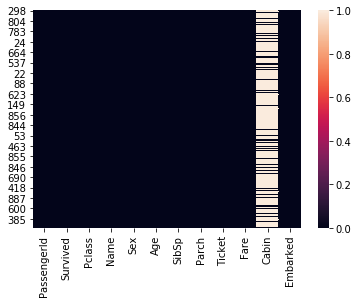

In [5]:
sns.heatmap(X_train.isna())

In [6]:
# Survival Rate
print('Survival Rate: {:0.2f}%'.format(X_train.Survived.value_counts()[1] * 100 / X_train.Survived.count()))

# Survival Rate by Gender
print('Survival Rate by Gender:')

print('\tFemale: {:0.2f}%'.format(X_train.groupby('Sex').Survived.mean()['female'] * 100))
print('\tMale: {:0.2f}%'.format(X_train.groupby('Sex').Survived.mean()['male'] * 100))

# Survival Rate by Pclass
print('Survival Rate by Pclass:')

print(X_train.groupby('Pclass').Survived.mean())

Survival Rate: 37.87%
Survival Rate by Gender:
	Female: 74.24%
	Male: 18.91%
Survival Rate by Pclass:
Pclass
1    0.611842
2    0.482270
3    0.245333
Name: Survived, dtype: float64


Survival Rate by Age:
Survived
0    30.273901
1    28.303930
Name: Age, dtype: float64
Statistical Significance:
	T-Statistic: 1.9001470349295901
	P-Value: 0.05784543798792019


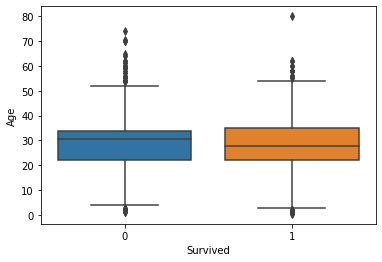

In [7]:
# Survival Rate by Age
print('Survival Rate by Age:')
sns.boxplot(
    x='Survived',
    y='Age',
    data=X_train
)

print(X_train.groupby('Survived').Age.mean())

# Difference statistically significant?
stat, p = ttest_ind(X_train[X_train.Survived == 0].Age.dropna(), X_train[X_train.Survived == 1].Age.dropna())
print('Statistical Significance:')
print('\tT-Statistic: {}'.format(stat))
print('\tP-Value: {}'.format(p))

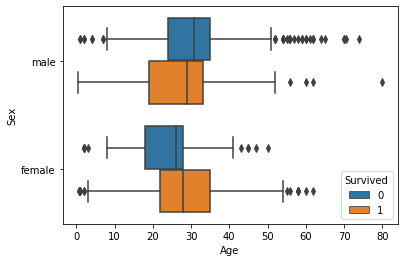

In [8]:
sns.boxplot(
    x='Age',
    y='Sex',
    hue='Survived',
    data=X_train
)

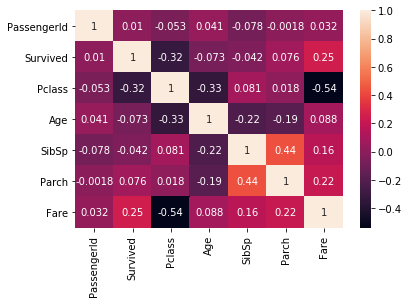

In [9]:
sns.heatmap(X_train.corr(), annot=True)

In [10]:
# Baselines
print('Baselines')

# If I predict that everyone dies
print('If I predict that everyone survives: {:0.2f}%'.format((X_train.Survived == 0).mean() * 100))

# If I predict that all females live
print('If I predict that all females live: {:0.2f}%'.format((X_train.Sex == 'female').mean() * 100))

# If I predict that all females live and all males die
print('If I predict that all females live and all males die: {:0.2f}%'.format(pd.concat([X_train[X_train.Sex == 'male'].Survived == 0, X_train[X_train.Sex == 'female'].Survived == 1]).mean() * 100))

Baselines
If I predict that everyone survives: 62.13%
If I predict that all females live: 34.28%
If I predict that all females live and all males die: 78.74%


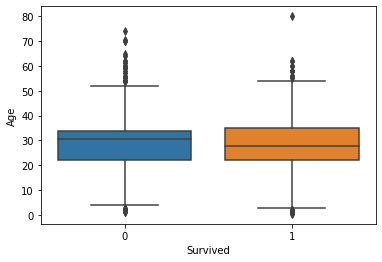

In [11]:
sns.boxplot(
    x='Survived',
    y='Age',
    data=X_train
)

In [12]:
X_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Feature Engineering

Plan:

- Remove 
    - PassengerID
    - Cabin
    - Ticket
- Engineer Prefix based on Name
- Impute Age using averages per gender and prefix
    - Interaction term between Sex and Age
- Transform SibSp and Parch values to 0 or 1
    - Interaction term between SibSp and Parch
- Normalize Fare (Std)
    - Interaction term between Fare and Age
- One-Hot Encoding on:
    - Prefix
    - Pclass
    - Sex
    - SibSp
    - Parch
    - SibSp vs. Parch
    - Embarked

In [13]:
X_train.loc[(X_train.Sex == 'female') & (X_train.Pclass == 2)].Age.mean()

28.32095217823187

In [14]:
regular_prefixes = ['Mr', 'Miss', 'Mrs', 'Master']
X_train.Name.apply(lambda x: x.split(', ')[1].split('. ')[0] if x.split(', ')[1].split('. ')[0] in regular_prefixes else 'Special').value_counts()

Mr         393
Miss       134
Mrs         89
Master      32
Special     20
Name: Name, dtype: int64

## Debugging Feature Engineering Function

In [15]:
debug_df_predictor, debug_df_response, debug_df_master = feature_engineer(X_train)
debug_df_predictor.columns

Index(['SibSp_bin', 'Parch_bin', 'Prefix_Miss', 'Prefix_Mr', 'Prefix_Mrs',
       'Prefix_Special', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Age_normalized', 'Fare_normalized'],
      dtype='object')

In [16]:
debug_df_predictor['Age_Sex_Interaction'] = debug_df_predictor.Age_normalized * debug_df_predictor.Sex_male
debug_df_predictor['Age_Fare_Interaction'] = debug_df_predictor.Age_normalized * debug_df_predictor.Fare_normalized

# Without Interaction
lr = LogisticRegression()

lr.fit(debug_df_predictor.loc[:, ['Sex_male', 'Age_normalized', 'Fare_normalized']], debug_df_response)
y_pred = lr.predict(debug_df_predictor.loc[:, ['Sex_male', 'Age_normalized', 'Fare_normalized']])

print('Without Interaction\n')
print_confusion_matrix(debug_df_response, y_pred)
print(lr.coef_)

# With Interaction
lr = LogisticRegression()

lr.fit(debug_df_predictor.loc[:, ['Sex_male', 'Age_normalized', 'Fare_normalized', 'Age_Sex_Interaction', 'Age_Fare_Interaction']], debug_df_response)
y_pred = lr.predict(debug_df_predictor.loc[:, ['Sex_male', 'Age_normalized', 'Fare_normalized', 'Age_Sex_Interaction', 'Age_Fare_Interaction']])

print('\nWith Interaction\n')
print_confusion_matrix(debug_df_response, y_pred)
print(lr.coef_)

# With everything
lr = LogisticRegression()

lr.fit(debug_df_predictor, debug_df_response)
y_pred = lr.predict(debug_df_predictor)

print('Without Interaction\n')
print_confusion_matrix(debug_df_response, y_pred)
print(lr.coef_)

Without Interaction

Confusion Matrix:
[[353  62]
 [ 80 173]]
Accuracy: 78.74%
Recall: 81.52%
Precision: 85.06%
[[-2.30829073 -0.12029848  0.57287744]]

With Interaction

Confusion Matrix:
[[353  62]
 [ 80 173]]
Accuracy: 78.74%
Recall: 81.52%
Precision: 85.06%
[[-2.40617698  0.27022779  0.54460214 -0.65450792  0.11327885]]
Without Interaction

Confusion Matrix:
[[370  45]
 [ 69 184]]
Accuracy: 82.93%
Recall: 84.28%
Precision: 89.16%
[[-0.45167289 -0.44402361 -0.2983007  -1.80663644  0.52998463 -0.82011982
  -0.47976155 -1.77581209 -1.12545048 -0.24158648 -0.62249608 -0.15792917
   0.14480421 -0.29377037  0.20109668]]


## Feature Engineer X_train and X_test

In [17]:
X_train_final, y_train_final, train_final = feature_engineer(X_train)
X_test_final, y_test_final, test_final = feature_engineer(X_test)
print(X_train_final.columns)
print(X_test_final.columns)

Index(['SibSp_bin', 'Parch_bin', 'Prefix_Miss', 'Prefix_Mr', 'Prefix_Mrs',
       'Prefix_Special', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Age_normalized', 'Fare_normalized'],
      dtype='object')
Index(['SibSp_bin', 'Parch_bin', 'Prefix_Miss', 'Prefix_Mr', 'Prefix_Mrs',
       'Prefix_Special', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Age_normalized', 'Fare_normalized'],
      dtype='object')


## Model Building

In [45]:
models = {}

# Logistic Regression
lr = LogisticRegression(max_iter = 2000)
lr.fit(X_train_final, y_train_final)
y_pred = lr.predict(X_test_final)

models['Logistic Regression'] = set_confusion_matrix(y_test_final, y_pred)

# Coefficients
models['Logistic Regression']['Coefficients'] = {}

for i in range(len(X_train_final.columns)):
    models['Logistic Regression']['Coefficients'][X_train_final.columns[i]] = lr.coef_[0][i]
models['Logistic Regression']['Coefficients']['Intercept'] = lr.intercept_

# SVC
svc = SVC(probability=True)
svc.fit(X_train_final, y_train_final)
y_pred = svc.predict(X_test_final)

models['SVC'] = set_confusion_matrix(y_test_final, y_pred)

# XG Boost
xgb = XGBClassifier(random_state=1)
xgb.fit(X_train_final, y_train_final)
y_pred = xgb.predict(X_test_final)

models['XGBoost'] = set_confusion_matrix(y_test_final, y_pred)

# GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_final, y_train_final)
y_pred = gnb.predict(X_test_final)

models['Gaussian Naive Bayes'] = set_confusion_matrix(y_test_final, y_pred)


In [19]:
model_metrics = pd.DataFrame(models, columns=models.keys()).T
model_metrics

,matrix,accuracy,recall,precision
Logistic Regression,"[[72, 62], [10, 79]]",67.713,87.8049,53.7313
SVC,"[[112, 22], [24, 65]]",79.3722,82.3529,83.5821
XGBoost,"[[71, 63], [10, 79]]",67.2646,87.6543,52.9851
Gaussian Naive Bayes,"[[109, 25], [32, 57]]",74.4395,77.305,81.3433


## Model Tuning

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score:', classifier.best_score_)
    print('Best Parameters:', classifier.best_params_)
    print('Best Index:', classifier.best_index_)

In [21]:
# Logistic Regression
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf_lr = clf_lr.fit(X_train_final, y_train_final)
clf_performance(best_clf_lr, 'Logistic Regression')

lr = best_clf_lr.best_estimator_
y_pred = lr.predict(X_test_final)

# Confusion Matrix
print_confusion_matrix(y_test_final, y_pred)

print('Feature Coefficients:')
for i in range(len(X_train_final.columns)):
    print('\t' + X_train_final.columns[i] + ': {:0.6f}'.format(lr.coef_[0][i]))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.817383009763214
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Index: 21
Confusion Matrix:
[[78 56]
 [12 77]]
Accuracy: 69.51%
Recall: 86.67%
Precision: 58.21%
Feature Coefficients:
	SibSp_bin: -0.442385
	Parch_bin: -0.492201
	Prefix_Miss: -0.069115
	Prefix_Mr: -1.989434
	Prefix_Mrs: 0.935055
	Prefix_Special: -1.013196
	Pclass_2: -0.409458
	Pclass_3: -1.674325
	Sex_male: -0.615885
	Embarked_Q: -0.189890
	Embarked_S: -0.587887
	Age_normalized: -0.315842
	Fare_normalized: 0.215592


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.7s finished


In [22]:
# SVC
svc = SVC(probability = True)

param_grid = tuned_parameters = [
    {
        'kernel': ['rbf'],
        'gamma': [.1,.5,1,2,5,10],
        'C': [.1, 1, 10, 100, 1000]
    },
    # {
    #     'kernel': ['linear'],
    #     'C': [.1, 1, 10, 100, 1000]
    # },
    # {
    #     'kernel': ['poly'],
    #     'degree' : [2,3,4,5],
    #     'C': [.1, 1, 10, 100, 1000]
    # }
]

clf_svc = GridSearchCV(svc, param_grid=param_grid, cv=20, verbose=True, n_jobs=-1)
best_clf_svc = clf_svc.fit(X_train_final, y_train_final)
clf_performance(best_clf_svc, 'SVC')

svc = best_clf_svc.best_estimator_
y_pred = svc.predict(X_test_final)

# Confusion Matrix
print_confusion_matrix(y_test_final, y_pred)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   11.1s finished


Fitting 20 folds for each of 30 candidates, totalling 600 fits
SVC
Best Score: 0.8157754010695186
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Index: 6
Confusion Matrix:
[[116  18]
 [ 27  62]]
Accuracy: 79.82%
Recall: 81.12%
Precision: 86.57%


In [23]:
# SVC w/ optimized parameters
svc = SVC(probability=True, C=1, gamma=0.1, kernel='rbf')

svc.fit(X_train_final, y_train_final)
y_pred = svc.predict(X_test_final)

print_confusion_matrix(y_test_final, y_pred)

Confusion Matrix:
[[116  18]
 [ 27  62]]
Accuracy: 79.82%
Recall: 81.12%
Precision: 86.57%


In [24]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_final, y_train_final)
y_pred = rfc.predict(X_test_final)

print_confusion_matrix(y_test_final, y_pred)

Confusion Matrix:
[[72 62]
 [15 74]]
Accuracy: 65.47%
Recall: 82.76%
Precision: 53.73%


## Submission

Going w/ SVC w/ Optimized Paramters using old feature engineering function

In [48]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
test_data['Survived'] = pd.read_csv('data/base_submission.csv').Survived
# test_data['Survived'] = pd.read_csv('data/gender_submission.csv').Survived

genders = ['male', 'female']
for g in genders:
    train_data.loc[(train_data.Sex == g) & (train_data.Age.isna()), 'Age'] = train_data.loc[(train_data.Sex == g)].Age.mean()
    test_data.loc[(test_data.Sex == g) & (test_data.Age.isna()), 'Age'] = test_data.loc[(test_data.Sex == g)].Age.mean()

X_train, y_train, train_all = feature_engineer(train_data)
X_test, y_test, test_all = feature_engineer(test_data)

# Missing Fare
missing_fare_gender = int(X_test[X_test.Fare_normalized.isna()].Sex_male)
X_test[X_test.Fare_normalized.isna()] = X_train.loc[X_train.Sex_male == missing_fare_gender].Fare_normalized.mean()

# # SVC w/ optimized parameters
svc = SVC(probability=True, C=1, gamma=0.1, kernel='rbf')

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_test = test_data.Survived

print_confusion_matrix(y_test, y_pred)

y_pred_final = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_pred})
y_pred_final.to_csv('submissions/titanic_submission.csv', index=False)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived'],
      dtype='object')
Confusion Matrix:
[[248  22]
 [ 26 122]]
Accuracy: 88.52%
Recall: 90.51%
Precision: 91.85%


In [46]:
models['Logistic Regression']['Coefficients']

{'SibSp_bin': -0.452919127616809,
 'Parch_bin': -0.4834785346961648,
 'Prefix_Miss': -0.47753269124217035,
 'Prefix_Mr': -1.9743141145282666,
 'Prefix_Mrs': 0.5174270870423994,
 'Prefix_Special': -1.0187651212841464,
 'Pclass_2': -0.42118586897963645,
 'Pclass_3': -1.6829960327262028,
 'Sex_male': -1.0446697158430391,
 'Embarked_Q': -0.23557893914759606,
 'Embarked_S': -0.6425434030280791,
 'Age_normalized': -0.3143940523418301,
 'Fare_normalized': 0.20684439799364,
 'Intercept': array([3.01514002])}